In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from scipy.stats import spearmanr
import os

In [2]:
df_transactions = pd.read_csv("C:/Users/felix.oechslein/Desktop/Analysen Elphi, Mai/Rohdaten/"
                                    "transactions_ohne_vorname.csv")

C:\Users\felix.oechslein\AppData\Local\Temp\ipykernel_16176\3138028382.py:1: DtypeWarning: Columns (15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_transactions = pd.read_csv("C:/Users/felix.oechslein/Desktop/Analysen Elphi, Mai/Rohdaten/"


### 1. Transactions Bereinigung

In [7]:
df_t_bereinigt = df_transactions[["iid", "key", "attrtype", "status", "pricetotal", "createdprovider"]]
df_t_bereinigt["pricetotal"] = pd.to_numeric(df_t_bereinigt["pricetotal"], errors = "coerce")
df_t_bereinigt = df_t_bereinigt.query('attrtype == "TI"')
df_t_bereinigt = df_t_bereinigt.query('status == "Buchung" or status == "Order"')
df_t_bereinigt = df_t_bereinigt.query('pricetotal >= 0.01')
searchfor = ['TEST']
#searchfor = ['TEST', 'JET', "WS"]
df_t_bereinigt = df_t_bereinigt[~df_t_bereinigt["key"].str.contains('|'.join(searchfor))]
df_t_bereinigt.head()

C:\Users\felix.oechslein\AppData\Local\Temp\ipykernel_16176\2812688266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_bereinigt["pricetotal"] = pd.to_numeric(df_t_bereinigt["pricetotal"], errors = "coerce")


,iid,key,attrtype,status,pricetotal,createdprovider
0,186997381,JET_1_a502170,TI,Order,29.0,20181001161200
1,186997381,JET_1_a502170,TI,Order,29.0,20181001161200
2,176001157,JET_1_a502171,TI,Order,52.0,20181001161300
3,176001157,JET_1_a502171,TI,Order,52.0,20181001161300
5,176001157,JET_1_a502171,TI,Order,52.0,20181001161300


##### creation als datetime

In [8]:
df_t_bereinigt["createdprovider"] = pd.to_datetime(df_t_bereinigt['createdprovider'], format='%Y%m%d%H%M%S')
df_t_bereinigt.rename(columns = {"createdprovider" : "date"}, inplace = True)
df_t_bereinigt.head()

,iid,key,attrtype,status,pricetotal,date
0,186997381,JET_1_a502170,TI,Order,29.0,2018-10-01 16:12:00
1,186997381,JET_1_a502170,TI,Order,29.0,2018-10-01 16:12:00
2,176001157,JET_1_a502171,TI,Order,52.0,2018-10-01 16:13:00
3,176001157,JET_1_a502171,TI,Order,52.0,2018-10-01 16:13:00
5,176001157,JET_1_a502171,TI,Order,52.0,2018-10-01 16:13:00


##### Einträge für jede iid im Zeitverlauf sortieren

In [9]:
df_t_bereinigt = df_t_bereinigt.sort_values(by=["iid", "date"])

In [10]:
df_t_bereinigt.head()

,iid,key,attrtype,status,pricetotal,date
2777553,163094976,JET_1_a702292,TI,Order,10.0,2019-06-30 16:57:00
2777554,163094976,JET_1_a702292,TI,Order,10.0,2019-06-30 16:57:00
3123185,163094976,JET_1_a1094864,TI,Order,10.0,2021-06-04 16:33:00
3123186,163094976,JET_1_a1094864,TI,Order,10.0,2021-06-04 16:33:00
3123788,163094976,JET_1_a1095070,TI,Order,8.0,2021-06-04 19:54:00


##### Anzahl der unique Käufe 

In [18]:
df_t_bereinigt = df_t_bereinigt.loc[df_t_bereinigt.groupby(["iid", "key"])["date"].idxmin()]
df_t_bereinigt = df_t_bereinigt[["iid", "date"]]
df_t_bereinigt.head()

,iid,date
3123185,163094976,2021-06-04 16:33:00
3123788,163094976,2021-06-04 19:54:00
626619,163094976,2021-09-28 12:01:00
970102,163094976,2021-10-28 17:43:00
1549632,163094976,2021-12-21 18:20:00


##### Monate als t = 1, .... abspeichern

In [19]:
# Berechnung der neuen Spalte "month_count"
df_t_bereinigt['month_count'] = (df_t_bereinigt['date'].dt.year - 2022) * 12 + df_t_bereinigt['date'].dt.month - 3 - 1
df_t_bereinigt.head()

,iid,date,month_count
3123185,163094976,2021-06-04 16:33:00,-10
3123788,163094976,2021-06-04 19:54:00,-10
626619,163094976,2021-09-28 12:01:00,-7
970102,163094976,2021-10-28 17:43:00,-6
1549632,163094976,2021-12-21 18:20:00,-4


(array([22153., 22507., 28690., 11254., 16401., 21436., 15369., 22363.,
        23946., 21312., 16763., 22891., 22639.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13.]),
 <BarContainer object of 13 artists>)

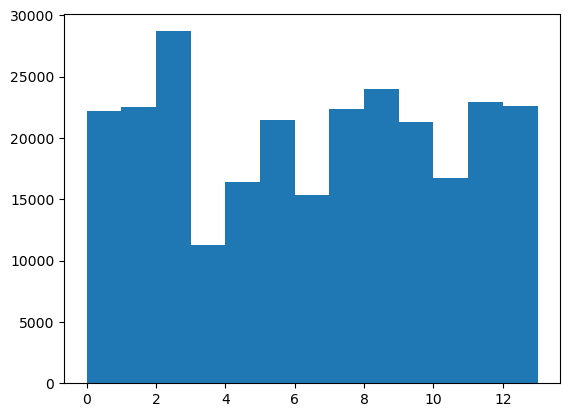

In [23]:
plt.hist(df_t_bereinigt[df_t_bereinigt['month_count'] >= 0]["month_count"], bins = 13)

In [25]:
df_t_bereinigt[df_t_bereinigt['month_count'] >= 0]["month_count"].max()

13

#### 2. verarbeiteteDaten als Elphi_transactions_ersteBereinigung.csv in dem Ordner verarbeitete_Daten abspeichern

In [26]:
path = r'C:/Users/felix.oechslein/Desktop/Analysen Elphi, Mai/verarbeitete_daten/'
filename = 'Elphi_transactions_ersteBereinigung.csv'

df_t_bereinigt.to_csv(os.path.join(path, filename), index=False)